In [2]:
import numpy as np
import scipy.integrate as integrate
%pylab inline


Populating the interactive namespace from numpy and matplotlib


### 3 CVA/DVA Exercise

###### Swap Object and Pricing

In [3]:
class Swap(object) :
    def __init__(self, maturity, coupon, freq, notional) :
        '''
        Args:
            maturity: in years
            coupon:   fixed coupon, in decimal
            freq:     frequency of payments, 2 for semi-annual
        
        '''
        self.maturity = maturity
        self.coupon = coupon
        self.freq = freq
        self.notional = notional
        
    def __str__(self) :
        return 'Swap: maturity %g, coupon %g, freq %g, notional %g'% \
        (self.maturity, self.coupon, self.freq, self.notional)
    
def priceSwap(swap, payerOrReceiver, P_OIS, P_LIBOR, i, ts, Tis, sim_freq) :
    '''
    Args:
        swap:     a swap object
        payerOrReceiver: string type, 'payer' or 'receiver'
        P_OIS:    array, discount bond price using OIS
        P_Libor:  array, discount bond price using LIBOR
        i:        time step now, takes positive integer
        ts:       simulation time steps
        Tis:      payment time steps
        
    return:
        price:    value of swap at time ts[i]
    '''
    c = swap.coupon * swap.notional/swap.freq # fixed coupon
    dT = Tis[1]-Tis[0]
    first_stub = np.where(Tis>=ts[i])[0][0]
    floating = []
    # first add the first (past set) stub where T_(i-1)<t
    if first_stub != 0:
        floating.append((1./P_LIBOR[first_stub*sim_freq/swap.freq-1][1]-1.)/dT)
    else:
        floating.append((1./P_LIBOR[0][sim_freq/swap.freq-1]-1.)/dT)
    
    # then add the rest floating payments using Expectation
    for j in range(1,len(P_LIBOR[i+1]),1):
        floating.append((P_LIBOR[i+1][j-1]/P_LIBOR[i+1][j]-1.)/dT)
        
    if payerOrReceiver == 'payer':
        net_payment = np.asarray(floating) - c
    elif payerOrReceiver == 'receiver':
        net_payment = c - np.asarray(floating)
    else:
        print "!Error: please set the correct swap type"
        
    price = dT*np.sum(np.asarray(P_OIS[i+1]).dot(net_payment))
    return price

#### Market setup

In [24]:
def simulateXt_1(ts,sigma,kappa,wt,ind):
    '''
    One-factor Gaussian Model
    Args:
        ind: index of which row of wt to use, 2 for lbdaB, 3 lbdaC
        
    '''
    yt = sigma*sigma/2./kappa*(1.-np.exp(-2.*kappa*ts))
    xt = []
    x = 0
    dt = ts[1]-ts[0]
    for i in range(len(ts)):
        x = x + (yt[i] - kappa*x)*dt+sigma*np.sqrt(dt)*wt[ind][i]
        xt.append(x)
        
    return xt,yt
    


def simulateXt(rho_x, sigma1, sigma2, kappa1, kappa2, maturity,ts,wt):
    '''
    Two-factor Gaussian model
    Args:
        
    
    '''
    sigma22 = sigma2
    sigma21 = sigma1*rho_x
    sigma11 = np.sqrt(sigma1**2 *(1 - rho_x*rho_x))
    
    dt = ts[1]-ts[0]
    x = np.asarray([0,0])
    xt = []
    yt = []
    
    for i in range(maturity/dt):
        B = np.diag([np.exp(-kappa1*ts[i]),np.exp(-kappa2*ts[i])])
        
        integral_aa11 = (sigma11**2+sigma21**2)/2./kappa1*(np.exp(2*kappa1*ts[i])-1.)
        integral_aa12 = sigma21*sigma22/(kappa1+kappa2)*(np.exp((kappa1+kappa2)*ts[i])-1.)
        integral_aa22 = sigma22**2 /2./kappa2*(np.exp(2*kappa2*ts[i]-1.))
        integral_aa = np.asarray([[integral_aa11,integral_aa12],[integral_aa12,integral_aa22]])
        
        y = B.dot(integral_aa).dot(B)
        
        x = x + (y.dot(np.ones(2))-np.diag([kappa1,kappa2]).dot(x))*dt+np.diag([sigma1,sigma2]).dot(wt[0:2])
        xt.append(x)
        yt.append(y)
        
    return xt,yt
    
    
def simulateOIS(rho_x, sigma1, sigma2, kappa1, kappa2, sim_freq, maturity, f0_OIS, spread,ts,Tis):
    
    P_OIS = []
    P_LIBOR = []
    
    P_OIS.append([np.exp(-f0_OIS*t) for t in ts]) # calculate P_OIS(0,t) for all t
    P_LIBOR.append([P_OIS[0][i]*np.exp(-spread*ts[i]) for i in range(ts.shape[0])])# calculate P_LIBOR(0,t) for all t
    xt,yt = simulateXt(rho_x, sigma1, sigma2, kappa1, kappa2, maturity,ts) #120 xt's and yt's
    
    dt = ts[1]-ts[0]
    dT = Tis[1]-Tis[0]

    for i in range(ts.shape[0]):
        P_OIS_t = []
        P_OIS_0_t = P_OIS[0][i]
        P_LIBOR_t = []
        for j in np.where(Tis>=ts[i])[0]: # index for all coupon paying dates after t
            G = np.asarray([(1.-kappa1*(Tis[j]-ts[i]))/kappa1,(1.-kappa2*(Tis[j]-ts[i]))/kappa2])
            P_OIS_0_Ti = P_OIS[0][(j+1)*dT/dt-1]
            P_OIS_t_Ti = P_OIS_0_Ti/P_OIS_0_t*np.exp(-G.T.dot(xt[i])-0.5*G.T.dot(yt[i]).dot(G))
            P_OIS_t.append(P_OIS_t_Ti)
            P_LIBOR_t.append(P_OIS_t_Ti*np.exp(-spread*(Tis[j]-ts[i])))
            
        P_OIS.append(P_OIS_t)
        P_LIBOR.append(P_LIBOR_t)
        
    return P_OIS,P_LIBOR
    
def simulateSurvivalProb(lbda0_B,lbda0_C,ts,sigmaB,kappaB,sigmaC,kappaC,wt):
    XB = []
    XC = []

    XB.append([np.exp(-lbda0_B*t) for t in ts])
    XC.append([np.exp(-lbda0_C*t) for t in ts])
    xt_B,yt_B = simulateXt_1(ts,sigmaB,kappaB,wt,0)
    xt_C,yt_C = simulateXt_1(ts,sigmaC,kappaC,wt,1)
    
    for i in range(ts.shape[0]):
        XB_ti = []
        XC_ti = []
        for j in np.where(ts>=ts[i])[0]:
            G_B = (1.-np.exp(-kappaB*(ts[j]-ts[i]))/kappaB)
            XB_0_tj = XB[0][j]
            XB_0_ti = XB[0][i]
            XB_ti_tj = XB_0_tj/XB_0_ti*np.exp(-xt_B[i]*G_B-0.5*yt_B[i]*G_B*G_B)
            XB_ti.append(XB_ti_tj)
            
            G_C = (1.-np.exp(-kappaC*(ts[j]-ts[i]))/kappaC)
            XC_0_tj = XC[0][j]
            XC_0_ti = XC[0][i]
            XC_ti_tj = XC_0_tj/XC_0_ti*np.exp(-xt_C[i]*G_C-0.5*yt_C[i]*G_C*G_C)
            XC_ti.append(XC_ti_tj)
            
        XB.append(XB_ti)
        XC.append(XC_ti)
        
    return XB,XC
            

###### Simulate OIS curve

From equation (18) and (19) from [1], we get $$\sigma_{22}=\sigma_2$$
$$\sigma_{21}=\sigma_1 \times \rho_x$$
$$\sigma_{11}=\sqrt{\sigma_1^2-\sigma_{21}^2}=\sqrt{\sigma_1^2-\sigma_1^2\times \rho_x^2}$$
For $y(t)$, we calculate the involved integral manually:
$$\int_{0}^{t}{a(u)^T a(u)du}=\int_{0}^{t} \begin{bmatrix} \sigma_{11}^2e^{2\kappa_1u} & \sigma_{21}\sigma_{22}e^{(\kappa_1+\kappa_2)u}\\\sigma_{21}\sigma_{22}e^{(\kappa_1+\kappa_2)u} & \sigma_{22}^2e^{2\kappa_2u} \end{bmatrix}du \\=\begin{bmatrix} \frac{\sigma_{11}^2+\sigma_{21}^2}{2\kappa_1}(e^{2\kappa_1t}-1) & \frac{\sigma_{21}\sigma_{22}}{\kappa_1+\kappa_2}(e^{(\kappa_1+\kappa_2)t}-1) \\ \frac{\sigma_{21}\sigma_{22}}{\kappa_1+\kappa_2}(e^{(\kappa_1+\kappa_2)t}-1) & \frac{\sigma_{22}^2}{2\kappa_2}(e^{2\kappa_2t}-1)\end{bmatrix}$$
For $P(t,x(t),T)$, we know $$P(t,x(t),T)=e^{-\int_{t}^{T} f(t,x(t),u)du}$$ where $$f(t,x(t),u)=f(0,u)+M(t,u)^T(x(t)+y(t)G(t,u))$$
Since $f(0,u)$ is constant, then $$P(t,x(t),T)=e^{-f(0,T)+f(0,t)}e^{-x(t)\int_{t}^{T}M(t,u)du}e^{-y(t)\int_{t}^{T}M(t,u)^TG(t,u)du}\\=\frac{P(0,T)}{P(0,t)}exp\big(-G(t,T)^Tx(t)-\frac{1}{2}G(t,T)^Ty(t)G(t,T)\big)$$
where $$M(t,T)=\begin{bmatrix} e^{-\kappa_1(T-t)} \\ e^{-\kappa_2(T-t)}\end{bmatrix}$$
and $$G(t,T)=\int_{t}^{T}M(t,u)du=\int_{t}^{T}\begin{bmatrix} e^{-\kappa_1(T-t)} \\ e^{-\kappa_2(T-t)}\end{bmatrix}du\\=\begin{bmatrix} \frac{1-\kappa_1(T-t)}{\kappa_1} \\ \frac{1-\kappa_2(T-t)}{\kappa_2}\end{bmatrix}$$

###### Inputs

In [5]:
num_simulation = 50000
sim_freq = 12

### Interest rate parameters
spread = 0.005 # spread i.e. f_LIBOR=f_OIS+spread
f0_OIS = 0.02
f0_LIBOR = f0_OIS+spread

### swap parameters
freq = 2
maturity = 10
coupon = 0.0265
notional = 150000000.

### Interest rate model parameters
sigma_r = 0.02
c = 0.35
kappa1,kappa2 = 0.02,0.1
rho_inf = 0.4
nu = np.sqrt(1./c/c - 1. - 2.*(rho_inf/c - 1.))
rho_x = (rho_inf/c - 1.)*nu
sigma_l = c * sigma_r
sigma1 = sigma_l
sigma2 = nu*sigma1

### Credit curve parameters
lbda0_B, lbda0_C = 0.01,0.03
sigmaB, sigmaC = 0.005,0.01
kappaB, kappaC = 0.1,0.1

rho_Bf, rho_Cf = 0.1,0.1
rho_BC = 0.75
rho_Br, rho_Cr = 0.25,0.25
rho_B1 = rho_Bf   # corr b/w lbdaB and x1
rho_C1 = rho_Cf   # corr b/w lbdaC and x1
rho_B2 = rho_Br*np.sqrt(nu*nu+1.+2*rho_x*nu)-nu*rho_B1   # corr b/w lbdaB and x2
rho_C2 = rho_Cr*np.sqrt(nu*nu+1.+2*rho_x*nu)-nu*rho_C1   # corr b/w lbdaC and x2

### correlation matrix among lbdaB,lbdaC,x1,x2 for simulation
corr = np.array([[1., rho_BC, rho_B1, rho_B2],\
                 [rho_BC, 1., rho_C1, rho_C2],\
                 [rho_B1, rho_C1, 1., rho_x],\
                 [rho_B2, rho_C2, rho_x, 1.]])
chol = np.linalg.cholesky(corr)

In [ ]:
swap = Swap(maturity, coupon, freq, notional)
swap.__str__()

Tis = np.arange(1./freq,maturity+1e-6,1./freq)
ts = np.arange(1./sim_freq,maturity+1e-6,1./sim_freq)
prices=[]
for num in range(num_simulation):
    # simulate correlated 4-D brownian motion
    wt = chol.dot(np.random.normal(0,1./sim_freq,(4,sim_freq*maturity)))
    
    P_OIS, P_LIBOR = simulateOIS(rho_x, sigma1, sigma2, kappa1, kappa2, sim_freq, maturity, f0_OIS, spread,ts,Tis)
    X_B,X_C = simulateSurvivalProb(lbda0_B,lbda0_C,ts,sigmaB,kappaB,sigmaC,kappaC,wt)
    price_one_path=[]
    for i in range(maturity*sim_freq):
        price_one_path.append(priceSwap(swap, 'receiver', P_OIS, P_LIBOR, i, ts, Tis,sim_freq))
        
    prices.append(price_one_path)

In [25]:
wt = chol.dot(np.random.normal(0,1./sim_freq,(4,sim_freq*maturity)))
X_B,X_C = simulateSurvivalProb(lbda0_B,lbda0_C,ts,sigmaB,kappaB,sigmaC,kappaC,wt)
#plot(ts,X_B,ts,X_C)
print len(X_C)
print len(X_C[1])

121
120


[1.0076129402366936, 1.0067409764076638, 1.0058693441124258, 1.0049980587594116, 1.0041271353911496, 1.0032565886913942, 1.0023864329921321, 1.0015166822804569, 1.0006473502053241, 0.9997784500841832, 0.99890999490948695, 0.99804199735508603, 0.99717446978250857, 0.99630742424712093, 0.99544087250418212, 0.99457482601478409, 0.99370929595168622, 0.99284429320504275, 0.99197982838802479, 0.99111591184234116, 0.99025255364365661]


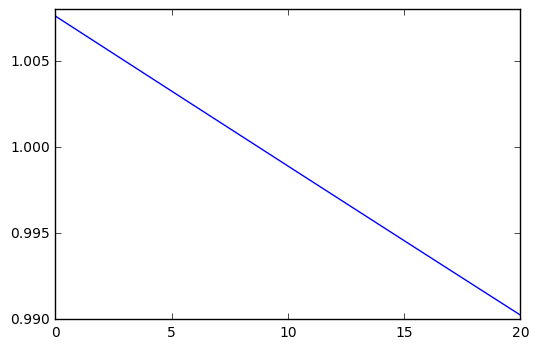

In [32]:
plot(X_B[100],)
print X_B[100]

In [6]:
plot(np.average(prices,axis=0));

TypeError: simulateOIS() takes exactly 12 arguments (10 given)

In [7]:
np.random.normal(0,1,(4,3))

array([[-1.5613746 ,  0.35010227, -0.91653306],
       [-0.10438003, -0.27719157, -0.60928736],
       [ 0.58390275,  1.71231875, -1.41108173],
       [-0.79196534, -0.02335912, -1.95858042]])

###### Credit Curve Setting

In [ ]:
# test cell
rho_x = 0.5
C = np.asarray([[1,0],[rho_x,1-rho_x*rho_x]]) # Cholesky decomposition of correlation matrix
wt = C.dot(np.random.normal(0,1,(2,)))
print wt.shape
print np.ones(2).shape
print np.diag(np.asarray([2,3]))
print np.arange(1./12,10.00001,1./12)

In [ ]:
print len(P_OIS[1])
print len(Tis)
print len(P_LIBOR[61])

### 4 IMM Exercise